# Auto-ARIMA model on Log returns file

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']

Forecasting for DE40


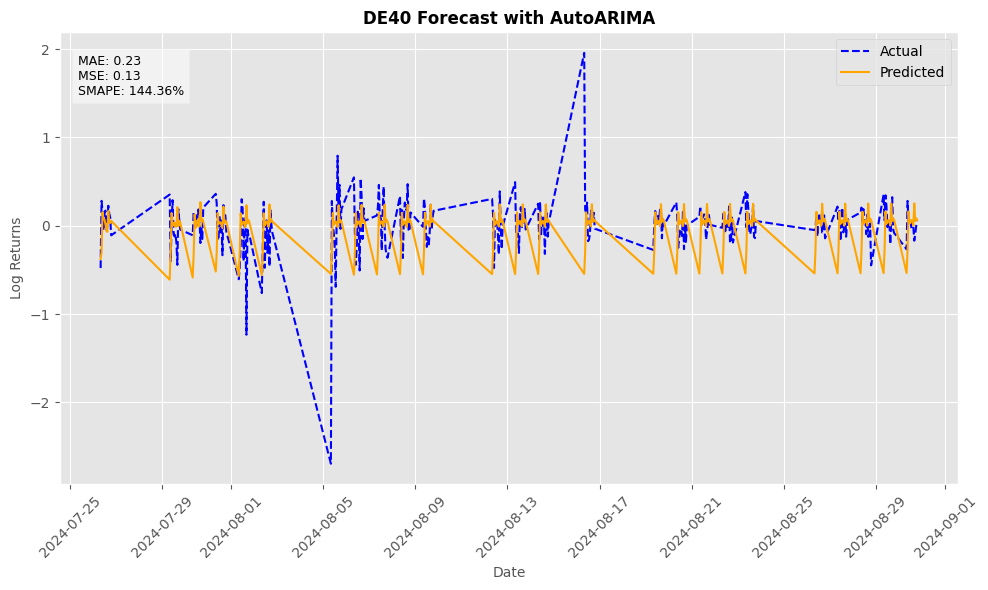


Forecasting for FR40


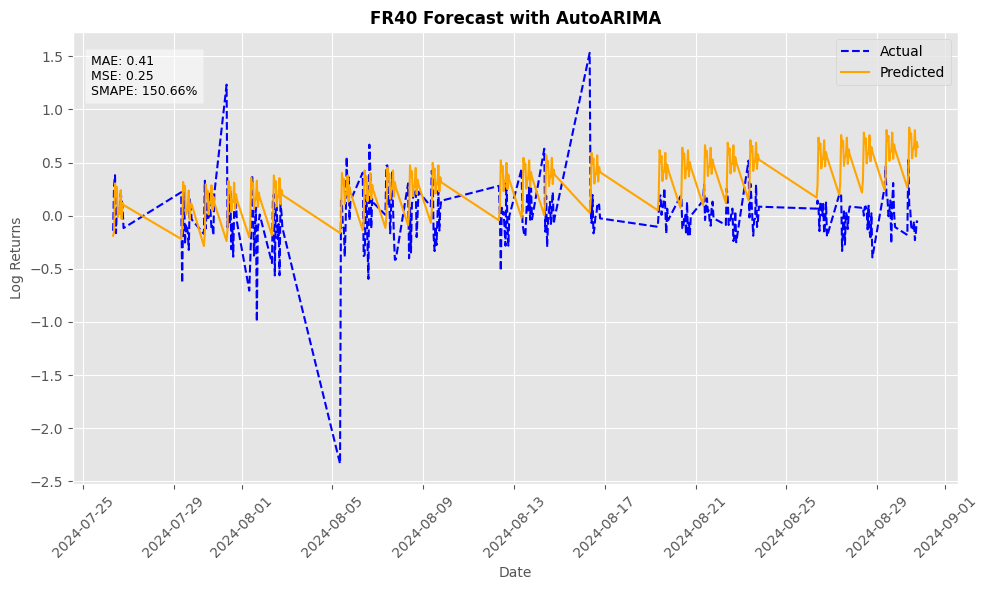


Forecasting for NL25


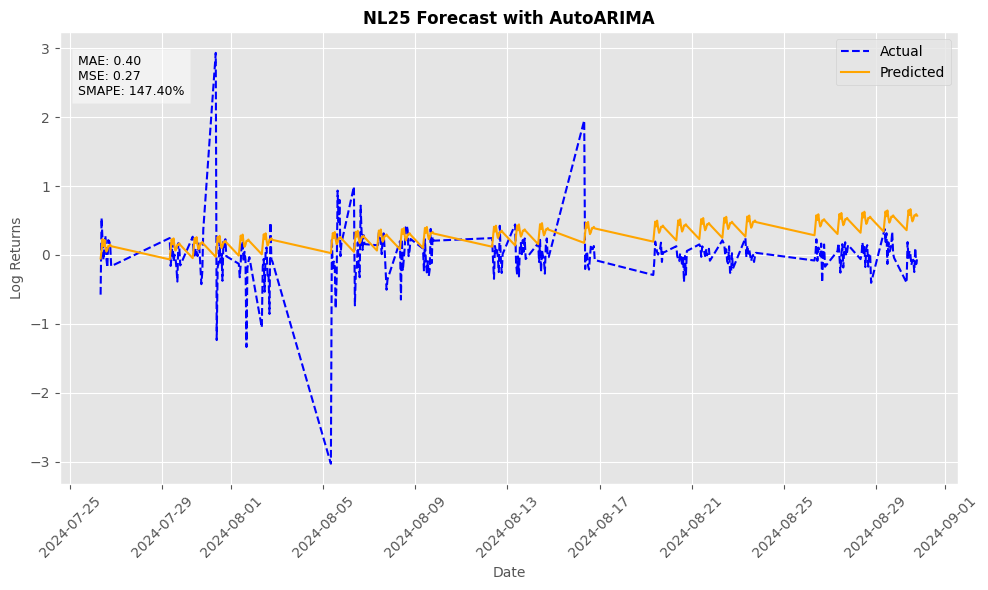


Forecasting for IT40


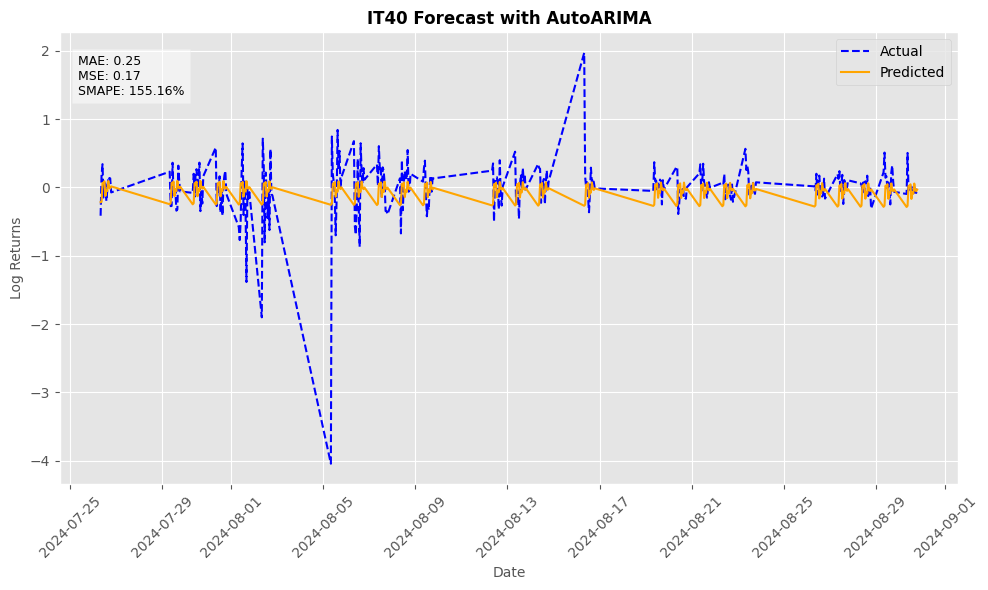


Forecasting for SP35


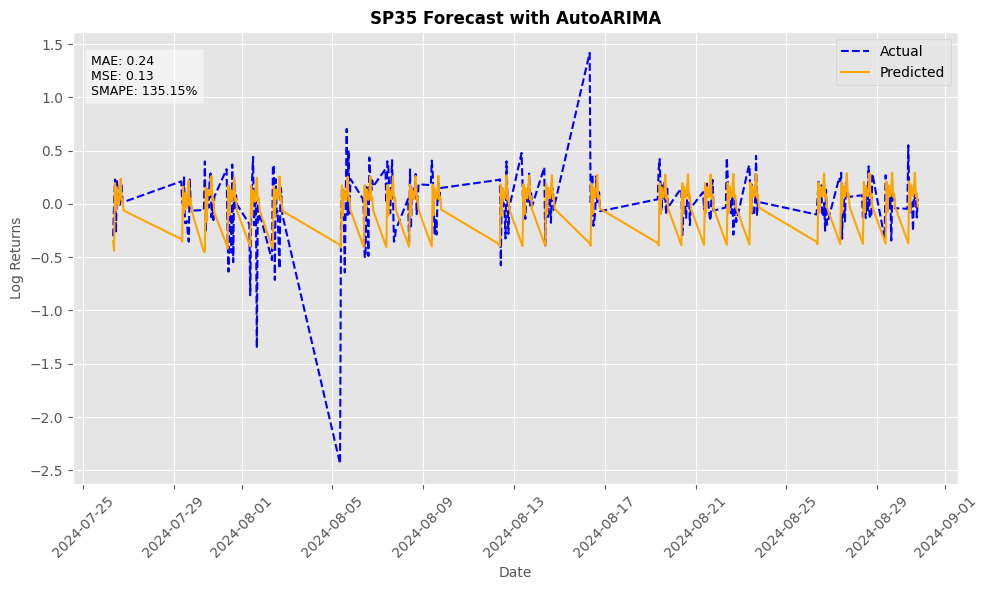


Forecasting for UK100


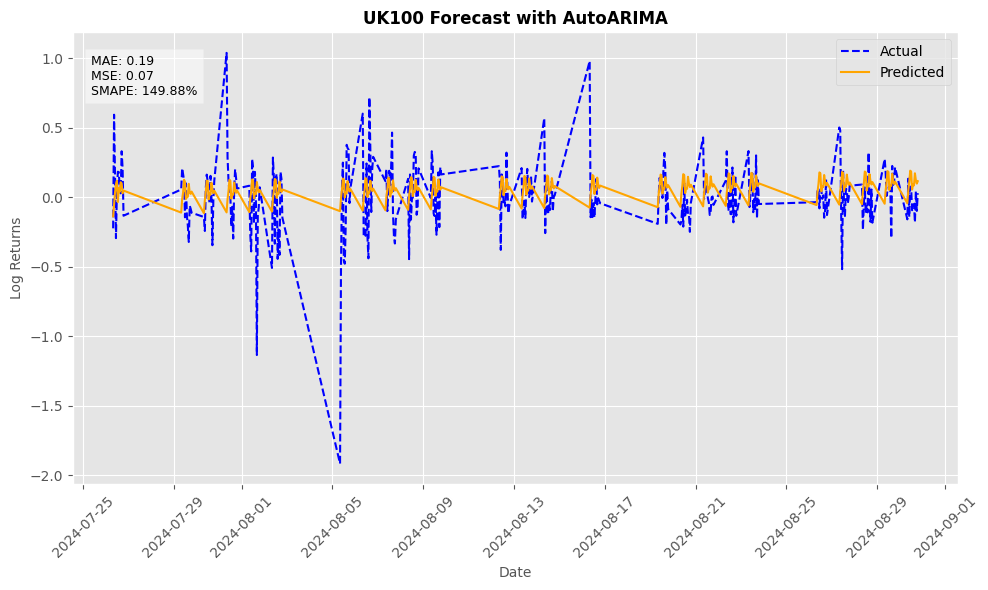


Forecasting for EU50


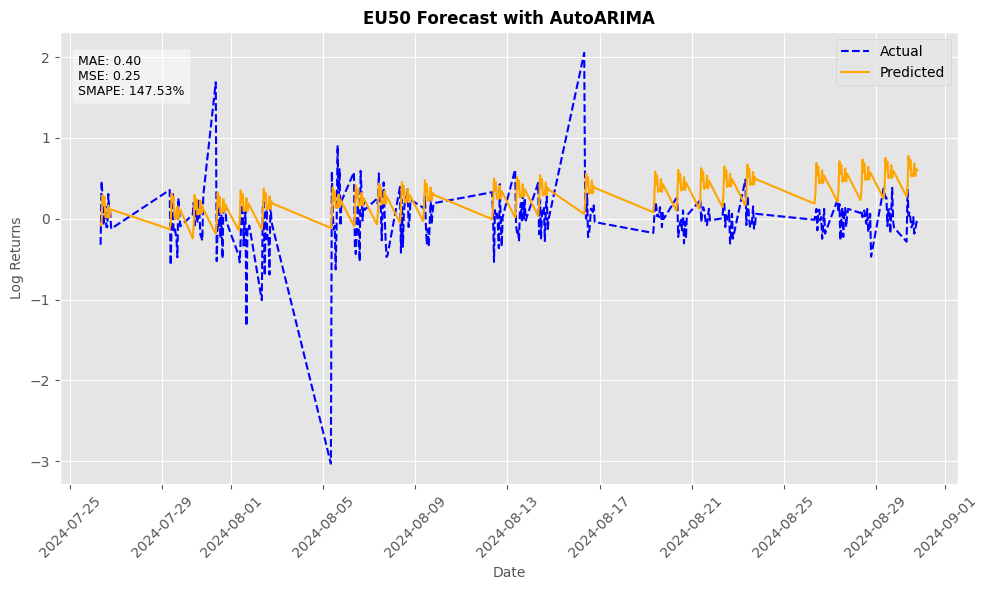

Forecasting Results Summary:
   Stock       MSE       MAE       SMAPE
0   DE40  0.131991  0.226392  144.358452
1   FR40  0.245284  0.408686  150.658196
2   NL25  0.268046  0.400965  147.397911
3   IT40  0.171481  0.251851  155.155151
4   SP35  0.125116  0.239437  135.145803
5  UK100  0.072788  0.190411  149.877375
6   EU50  0.251387  0.395949  147.526049


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Check available styles
print(plt.style.available)

# Root Mean Squared Error (RMSE) calculation
def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

# Symmetric Mean Absolute Percentage Error (SMAPE) calculation
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Load the data
df = pd.read_csv('modified_log_ret.csv', parse_dates=['datetime'])
df.set_index('datetime', inplace=True)

# Define the forecast horizon and season length
forecast_horizon = 300  
season_length = 12      # hourly seasonality

# Set plot style from available options
plt.style.use('ggplot')  # Use a valid style

# Initialize a list to store results for the table
results_list = []

# Iterate over each column to perform forecasting
for i, target_column in enumerate(df.columns):
    print(f"\nForecasting for {target_column}")

    # Prepare the data for StatsForecast
    forecast_df = df[[target_column]].reset_index()
    forecast_df.columns = ['ds', 'y']
    forecast_df['unique_id'] = target_column

    # Split the data into train and test sets
    train_df = forecast_df[:-forecast_horizon]
    test_df = forecast_df[-forecast_horizon:]

    # Set up the StatsForecast model with AutoARIMA
    model = AutoARIMA(season_length=season_length, seasonal=True, stepwise=True, d=1, D=1, max_order=30)
    
    try:
        # Fit the model
        forecast_model = StatsForecast(models=[model], freq='D')
        forecast_model.fit(train_df)

        # Forecast the next horizon
        forecast = forecast_model.predict(h=forecast_horizon, level=[95])

        # Retrieve the predictions
        predicted = forecast['AutoARIMA'].values
        actual = test_df['y'].values

        # Calculate MAE, MSE, SMAPE
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        smape_val = smape(actual, predicted)

        # Store the results in the list for the table
        results_list.append({
            'Stock': target_column,
            'MSE': mse,
            'MAE': mae,
            'SMAPE': smape_val
        })

        # Create a separate figure for each stock
        plt.figure(figsize=(10, 6))
        plt.plot(test_df['ds'], test_df['y'], label='Actual', color='blue', linestyle='--')
        plt.plot(test_df['ds'], predicted, label='Predicted', color='orange')

        # Add text with metrics to the top of the plot
        plt.text(0.02, 0.95,  f'MAE: {mae:.2f}\nMSE: {mse:.2f}\nSMAPE: {smape_val:.2f}%', 
                 transform=plt.gca().transAxes, fontsize=9, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        # Set titles and labels
        plt.title(f'{target_column} Forecast with AutoARIMA', fontsize=12, fontweight='bold')
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('Log Returns', fontsize=10)
        plt.legend()
        plt.grid(True)  # Enable grid

        # Rotate x-axis labels
        plt.xticks(rotation=45)

        # Show the plot
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error with {target_column}: {e}")

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Display the result table
print("Forecasting Results Summary:")
print(results_df)
